# 목차

- 폐렴아 기다려라!
    1. Set-up
    2. 데이터 가져오기
    3. 데이터 시각화
    4. CNN 모델링
    5. 데이터 imbalance 처리
    6. 모델 훈련
    7. 결과 확인
    
    
- 폐렴아 기다려라! [Project]
    1. 실험환경 Set-up
    2. 데이터 준비하기
    3. 데이터 시각화
    
        - agumentation 기법을 사용 후 베이스 모델과의 성능 비교
        
        - 모델 구조 변경을 통한 베이스 모델과의 성능 비교
        
    4. ResNet-18 구현
    5. 데이터 imbalance 처리
    6. 모델 훈련
    7. 결과 확인과 시각화
    
    
- 회고

## 폐렴아 기다려라!

1. Set-up

In [26]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [27]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


2. 데이터 가져오기

In [28]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [29]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [30]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [31]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [32]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [33]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [34]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [35]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [36]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [37]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [38]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [39]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

3. 데이터 시각화

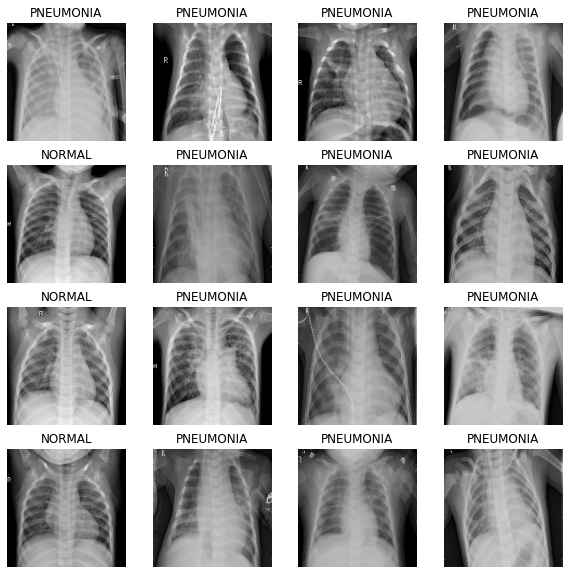

In [40]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

4. CNN 모델링

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

5. 데이터 imbalance 처리

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


6. 모델 훈련

In [42]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 120s 262ms/step - loss: 0.3839 - accuracy: 0.8180 - precision: 0.9572 - recall: 0.7909 - val_loss: 0.6628 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 96s 371ms/step - loss: 0.2177 - accuracy: 0.9162 - precision: 0.9739 - recall: 0.9118 - val_loss: 1.4562 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 98s 376ms/step - loss: 0.1985 - accuracy: 0.9255 - precision: 0.9759 - recall: 0.9228 - val_loss: 0.3993 - val_accuracy: 0.8250 - val_precision: 0.8078 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 101s 388ms/step - loss: 0.1709 - accuracy: 0.9375 - precision: 0.9813 - recall: 0.9335 - val_loss: 0.1170 - val_accuracy: 0.9510 - val_precision: 0.9419 - val_recall: 0.9948
Epoch 5/10
261/261 [==============================] - 102s 391ms/step - loss: 0.1536 - acc

7. 결과 확인

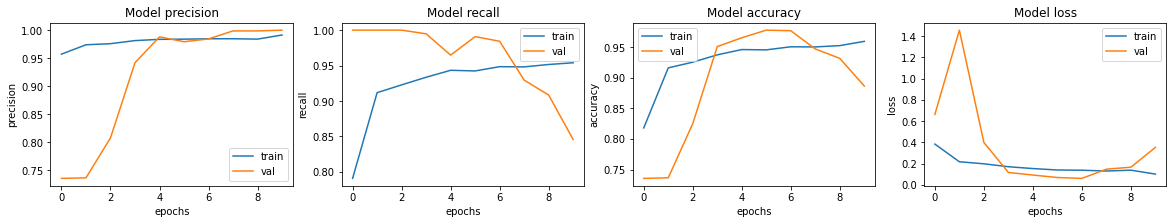

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 8s 187ms/step - loss: 0.4213 - accuracy: 0.8894 - precision: 0.8867 - recall: 0.9436
Loss: 0.42133620381355286,
Accuracy: 0.8894230723381042,
Precision: 0.8867470026016235,
Recall: 0.9435897469520569


## 폐렴아 기다려라! [Project]

프로젝트 : 폐렴 진단기 성능개선

In [46]:
import tensorflow

print(tensorflow.__version__)

2.6.0


Step 1. 실험환경 Set-up

In [47]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [48]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 15

print(ROOT_PATH)

/aiffel/aiffel


Step 2. 데이터 준비하기

In [49]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [50]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [51]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [52]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [53]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [54]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [55]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [56]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [57]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [58]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [59]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [60]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    image = tf.image.random_brightness(image, max_delta=0.1)  # 밝기 조정
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # 대비 조정
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

Step 3. 데이터 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

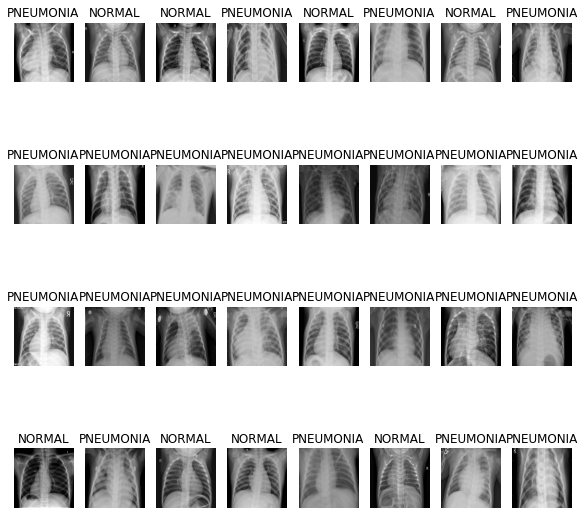

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
with tf.device('/GPU:0'):
    def show_batch(image_batch, label_batch):
        plt.figure(figsize=(10,10))
        for n in range(BATCH_SIZE):
            ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
            plt.imshow(image_batch[n])
            if label_batch[n]:
                plt.title("PNEUMONIA")
            else:
                plt.title("NORMAL")
            plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

* agumentation 기법을 사용 후 베이스 모델과의 성능 비교

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
130/130 [==============================] - 100s 409ms/step - loss: 0.4262 - accuracy: 0.7714 - precision: 0.9452 - recall: 0.7353 - val_loss: 0.5863 - val_accuracy: 0.7305 - val_precision: 0.7305 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 54s 413ms/step - loss: 0.2180 - accuracy: 0.9120 - precision: 0.9789 - recall: 0.9010 - val_loss: 0.8375 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 53s 410ms/step - loss: 0.1875 - accuracy: 0.9300 - precision: 0.9814 - recall: 0.9234 - val_loss: 1.0748 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 55s 423ms/step - loss: 0.1846 - accuracy: 0.9332 - precision: 0.9790 - recall: 0.9304 - val_loss: 1.3291 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 56s 435ms/step - loss: 0.1606 - accur

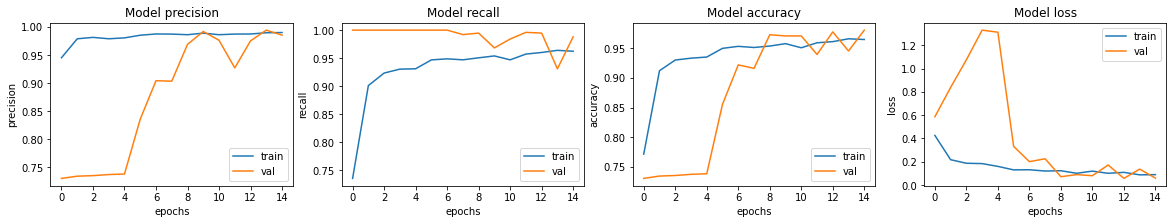

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 223ms/step - loss: 1.0064 - accuracy: 0.7356 - precision: 0.7057 - recall: 0.9897
Loss: 1.0063610076904297,
Accuracy: 0.7355769276618958,
Precision: 0.70566725730896,
Recall: 0.9897435903549194


정확도는 베이스 모델에 비해 낮은 것으로 보이나 진단에 있어 중요한 지표인 Recall 값이 높게 나온 것으로 보인다.

* 모델 구조 변경을 통한 베이스 모델과의 성능 비교

In [41]:
def conv_block(filters, dropout_rate=0.3, kernel_regularizer=None):

    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(
            filters, 
            3, 
            activation='relu', 
            padding='same',
            kernel_regularizer=kernel_regularizer
        ),
        tf.keras.layers.SeparableConv2D(
            filters, 
            3, 
            activation='relu', 
            padding='same',
            kernel_regularizer=kernel_regularizer
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(dropout_rate)  # 합성곱 블록 내 드롭아웃 추가
    ])
    
    return block

def dense_block(units, dropout_rate, kernel_regularizer=None):

    block = tf.keras.Sequential([
        tf.keras.layers.Dense(
            units, 
            activation='relu',
            kernel_regularizer=kernel_regularizer
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        # 첫 번째 합성곱 블록
        tf.keras.layers.Conv2D(
            16, 
            3, 
            activation='relu', 
            padding='same',
            kernel_regularizer=tf.keras.regularizers.l2(1e-4)  # L2 정규화 추가
        ),
        tf.keras.layers.Conv2D(
            16, 
            3, 
            activation='relu', 
            padding='same',
            kernel_regularizer=tf.keras.regularizers.l2(1e-4)  # L2 정규화 추가
        ),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.2),  # 추가적인 드롭아웃
        
        # 두 번째 합성곱 블록
        conv_block(32, dropout_rate=0.3, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        # 세 번째 합성곱 블록
        conv_block(64, dropout_rate=0.3, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        
        # 네 번째 합성곱 블록
        conv_block(128, dropout_rate=0.4, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        tf.keras.layers.Dropout(0.3),
        
        # 다섯 번째 합성곱 블록
        conv_block(256, dropout_rate=0.4, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        
        # 첫 번째 Dense 블록
        dense_block(512, dropout_rate=0.5, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        # 두 번째 Dense 블록
        dense_block(128, dropout_rate=0.4, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        # 세 번째 Dense 블록
        dense_block(64, dropout_rate=0.3, kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        
        tf.keras.layers.Dense(1, activation='sigmoid')  # 출력층
    ])
    
    return model

# 모델 생성
model = build_model()

# 모델 요약 출력
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_9 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_10 (Sequential)   (None, 11, 11, 128)     

In [43]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 63s 203ms/step - loss: 0.7189 - accuracy: 0.6856 - precision: 0.8893 - recall: 0.6594 - val_loss: 0.7195 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 53s 204ms/step - loss: 0.5094 - accuracy: 0.8355 - precision: 0.9468 - recall: 0.8252 - val_loss: 0.7495 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 54s 206ms/step - loss: 0.4028 - accuracy: 0.8908 - precision: 0.9709 - recall: 0.8796 - val_loss: 0.8135 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 53s 205ms/step - loss: 0.3671 - accuracy: 0.9114 - precision: 0.9701 - recall: 0.9088 - val_loss: 0.2631 - val_accuracy: 0.9577 - val_precision: 0.9558 - val_recall: 0.9882
Epoch 5/10
261/261 [==============================] - 54s 208ms/step - loss: 0.3533 - accura

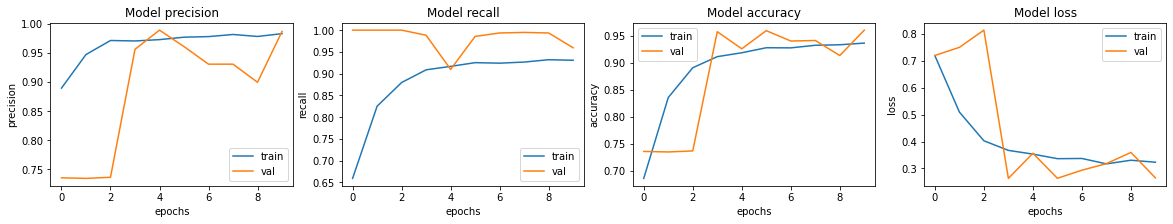

In [44]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [45]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 117ms/step - loss: 0.6894 - accuracy: 0.8333 - precision: 0.7942 - recall: 0.9897
Loss: 0.6894268989562988,
Accuracy: 0.8333333134651184,
Precision: 0.7942386865615845,
Recall: 0.9897435903549194


이전에 했던 실험과 비슷하게 정확성은 베이스 모델에 비해 다소 떨어지지만 Recall 값이 높은 것으로 보이며 베이스 모델은 6번째 훈련부터 과대적합의 요소가 보이는데 이를 방지하고 후에 더 많은 훈련을 통해 적합한 지점을 찾을 수 있을것으로 보인다.

Step 4. ResNet-18 구현

In [62]:
def residual_block(filters, strides=1):
    
    def block(x):
        # 첫 번째 3x3 Conv2D
        shortcut = x
        x = tf.keras.layers.Conv2D(filters, 3, strides=strides, padding='same', kernel_initializer='he_normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        
        # 두 번째 3x3 Conv2D
        x = tf.keras.layers.Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        # 입력과 출력의 크기가 다를 경우 shortcut을 맞춰줌
        if strides != 1 or shortcut.shape[-1] != filters:
            shortcut = tf.keras.layers.Conv2D(filters, 1, strides=strides, kernel_initializer='he_normal')(shortcut)
            shortcut = tf.keras.layers.BatchNormalization()(shortcut)
        
        # 잔차 연결 (Add)
        x = tf.keras.layers.Add()([x, shortcut])
        x = tf.keras.layers.ReLU()(x)
        
        return x
    return block

def build_resnet18(input_shape=(180, 180, 3), num_classes=1000):
    inputs = tf.keras.Input(shape=input_shape)
    
    # conv1: 7x7 Conv2D
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
   
    # conv2_x: 3x3 Conv2D 두 개, 잔차 연결
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    x = residual_block(64, strides=1)(x)  # [3x3, 64] * 2
    x = residual_block(64, strides=1)(x)  # [3x3, 64] * 2
    
    # conv3_x: 3x3 Conv2D 두 개, 잔차 연결
    x = residual_block(128, strides=1)(x)  # [3x3, 128] * 2
    x = residual_block(128, strides=1)(x)  # [3x3, 128] * 2
    
    # conv4_x: 3x3 Conv2D 두 개, 잔차 연결
    x = residual_block(256, strides=1)(x)  # [3x3, 256] * 2
    x = residual_block(256, strides=1)(x)  # [3x3, 256] * 2
    
    # conv5_x: 3x3 Conv2D 두 개, 잔차 연결
    x = residual_block(512, strides=1)(x)  # [3x3, 512] * 2
    x = residual_block(512, strides=1)(x)  # [3x3, 512] * 2
    
    # average pool
    x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(x)
    
    # fully connected layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    # 모델 구성
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# 모델 생성
model = build_resnet18(input_shape=(180, 180, 3), num_classes=1000)

# 모델 요약 출력
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 90, 90, 64)   9472        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 90, 90, 64)   256         conv2d_26[0][0]                  
__________________________________________________________________________________________________
re_lu_17 (ReLU)                 (None, 90, 90, 64)   0           batch_normalization_41[0][0]     
______________________________________________________________________________________________

Step 5. 데이터 imbalance 처리

In [63]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


Step 6. 모델 훈련

In [65]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [66]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
130/130 [==============================] - 63s 409ms/step - loss: 0.8410 - accuracy: 0.6373 - precision: 0.8531 - recall: 0.6182 - val_loss: 0.7383 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 52s 405ms/step - loss: 0.5833 - accuracy: 0.7897 - precision: 0.9334 - recall: 0.7729 - val_loss: 0.7225 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 53s 408ms/step - loss: 0.4522 - accuracy: 0.8685 - precision: 0.9566 - recall: 0.8623 - val_loss: 0.8291 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 53s 413ms/step - loss: 0.4029 - accuracy: 0.9055 - precision: 0.9694 - recall: 0.9013 - val_loss: 1.2268 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 55s 421ms/step - loss: 0.3667 - accura

Step 7. 결과 확인과 시각화

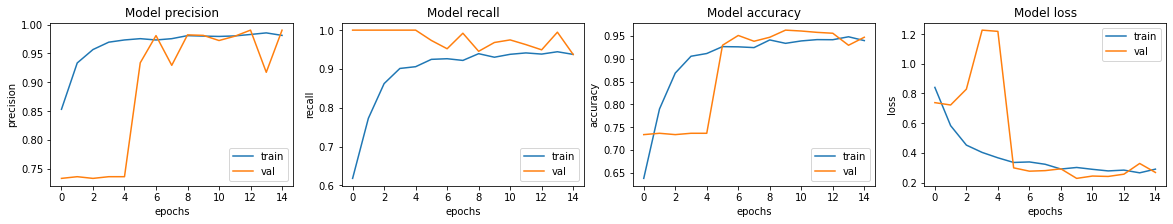

In [67]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [68]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 219ms/step - loss: 0.5908 - accuracy: 0.8349 - precision: 0.8140 - recall: 0.9538
Loss: 0.5907927751541138,
Accuracy: 0.8349359035491943,
Precision: 0.8140043616294861,
Recall: 0.9538461565971375


## 회고
```
모델을 설계하는 과정을 해보면서 상황에 적절한 데이터 증강이나, 드롭아웃, 규제 등이 도움이 되는것으로 보였다.
하지만 어떠한 원리로 수치가 변하는 것인지 잘 이해하지 못하였고 경험적인 부분이 큰 것인지 해결하지 못했다.
모델의 전반적인 구조는 두루뭉술하게 알 수는 있겠으나 정확한 이해와 설계 능력은 부족하게 느껴져 추가적인 학습은 필요할 것 같다.